# Classify Artwork images as either containing a person representation or not





## Introduction : 

Artworks such as paintings give us important clues about how people were perceived over centuries in the Western culture, for instance. Building a system that allows scholars to automatically find people in large database of paintings can help art historians and historians to analyse and study how the human representation changed over time.

The goal of this challenge is to classify artwork images as containing a person or not. 

While Reading the references mentioned in the overview panel on the challenge page, I noticed that in almost all the papers, They agree that the state of the art in image classifications is Neural Networks. 

$\implies$ That is why I focused my work on Neural Networks and especially Convolutional Neural Networks. 

## Data importing and preprocessing 

Because we will be using CNN models we need to store our data in an array in the RAM to make the training faster, plus we can do the preprocessing based on the whole data in the array. 

In [0]:
import os
import numpy as np
from google.colab import files
import tensorflow as tf 
import numpy as np
import pandas as pd
from skimage.io import imread 
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.optimizers import Adam,SGD
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler
from sklearn.metrics import f1_score 
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense,BatchNormalization
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from keras.preprocessing import image
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import f1_score

In [0]:
ROOT = './data/'
im_path = 'data/im/'
ext=".jpg"


In [0]:
#Download The Data From Kaggle Or You Can Use The Local Version   ! 
#install Kaggle package in order to be able to download the data 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c ima205-challenge-2020 -p './'  # use the kaggle package to download our dataset 
!unzip -q ima205-challenge-2020.zip -d ./ #unzip data 


kaggle.json
     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=7de0aa4e75131d53b1a415dbb748ec56ca152f579228b14145cc6353d79048e3
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
 98% 465M/472M [00:08<00:00, 59.1MB/s]
100% 472M/472M [00:08<00:00, 58.3MB/s]


In [0]:
!ls ./data

im  test.csv  train.csv


In [0]:

def load(filename,target_size):
  df = pd.read_csv(ROOT+filename) #Read the Train/Test Csv
  names = df['name'].values #extract images names 
  X=[] #Array in which we append the images
  for i in range(len(names)):
      if(not i%1000):
        print(i)
      img = imread(im_path+names[i]+ext)
      img = resize(img,(target_size,target_size,3), mode='reflect').astype(np.float32) # we resize the images into a fixed shape
                                                                                      # because we need the imput of the Cnn to h
                                                                                      # have the same shape, then we convert it into 
                                                                                      #np.float32 for memory issues because the data 
                                                                                      #to large to fit in the ram certainly with big 
                                                                                      #shapes.
      X.append(img)
  X=np.array(X) #convert the list into an numpy array
  return X

 Here we load out dataset into the ram. while training and running my models, I figured that the imput size matters and the bigger the image the better the results.

Thus I tried to use the biggest shape possible while not overflowing my RAM and the program crashing. 

In the best submission I used as image shape (400,400,3)

* Because the RAM can't fit all the data, first I load the trying data  and train my models $\implies$ save the best models $\implies$  clear the training data from the RAM by deleting the train data variable using (daily data) $\implies$ load the test data load the weight of the model $\implies $ make a prediction.

In [0]:
##Load the training data 
data=load("train.csv",400)
#del data
#data=load('test.csv',400)


0
1000
2000
3000
4000


## Preprocssing the Data : 


### Splitting the data: 

* Training data:  This is the data used to train the model, to fit the model parameters. It will account for the largest proportion of data as we wish for the model to see as many examples as possible.

* Test data :This is the data used to evaluate and compare models. As this data has not been seen during training nor tuning, it can provide insight into whether your models generalize well to unseen data.



### Scalling

* Scalling or Standardization  of the data : 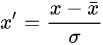 Where  $x$  is the original data vector, $\bar x$ is the mean of that data vector, and $\sigma$ is its standard deviation. 

* Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. The range of the data  should be normalized so that it contributes approximately proportionately in the gradient descent .

* Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it.




### Shuffling: 

* We need to shuffle the data, because if for example the data is stored as a sequence like [positive class observations, negative class observations] the model will first train on the positive observation, then adjust his weights to meet the negative class observation. This will lead, especially in the case of unbalanced data for the model to predict the majority class. 

* Tp prevent that we shuffle our data randomly to avoid any pattern in the data's order.



In [0]:
#Data normalization
data=data-data.mean() 
data=data/data.std()
#Data Shuffling 
p = np.random.permutation(len(data))
data=data[p]


In [0]:
####DO NOT RUN IF YOU LOADDED  THE TEST DATA TO MAKE A PREDICTION ! 
#data Split 
df = pd.read_csv(ROOT+"train.csv")
y=df["person"]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=666)
del data # we don't need this variable anymore and it take arround 10Gb in the ram , so it is wise to delete it .


##Classification Using From Scratch CNN Models:


In deep learning CNN models,  each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply activaiton(sigmoid) function to classify an object with probabilistic values between 0 and 1. 


The below figure is a complete flow of CNN to process an input image and classifies the objects based on values.
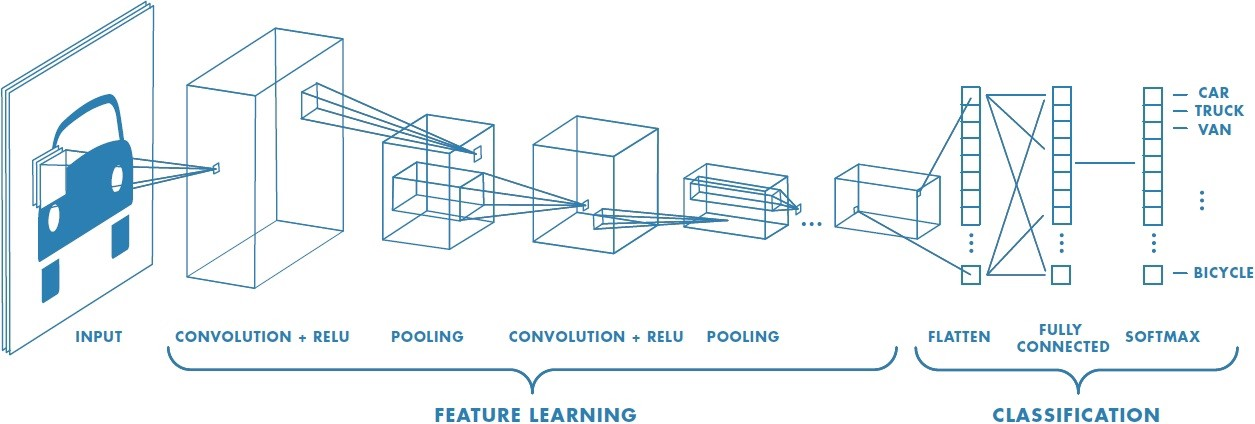

* Architecture of our CNN model: 
  * **INPUT** : Tensor(nbr of observations, shape of the image) 
  * **Convolution Network**:
  $\implies$ This layer consist in extracting features from the input data  using a sequence of convolution and  under sampling using maxppoling. 
    * Convolution Layer of 64 filter of size (3,3) with relu activation  
    * MaxPooling layer of size (2,2) 
    * Convolution Layer of 32 filter of size (3,3) with relu activation  
    * MaxPooling layer of size (2,2) 
    * Convolution Layer of 32 filter of size (3,3) with relu activation  
    * MaxPooling layer of size (2,2) 
  * **Flatten layer:**
  $\implies $ flatten the 2D tensor into 1D vector to ffed to our Fully Connected Network 
  
  * **Fully Connected Network :**
  $\implies $ This is the part that is responsible for the classification. The fully conected network use the features extracted from the Convolution Network to make the classification of the input image.

    * Dense layer with 128 neurone and relu activation
    * Dense layer with 64 neurone and relu activation 
    * Dense layer with 32 neurone and relu activation 
    * Dense layer with 1 neurone and segmoid activation 
  * **OUTPUT**: Tensor ( nbr of observation , 1) containing the probablty of the observation being an observation of class 1.


* I used the SAME padding because: 
 * VALID PADDING: reduce the size of the input with every convolution because it only uses the data of the image thus information loss if we apply consecutive convolutions 
 
 * SAME PADDING: using the SAME padding we add data to the input in order to keep the same input shape
 
 $\implies $ in both cases we are altering the data, I opted for the choice of NO DATA LOSS, so I used the SAME PADDING.

* Because the problem is a classification of  art work images either contains a person or not, we have 2 classes positive (presence of a person) and negative class (no person in the image) 

 $\implies $ this is a binary classification problem thus the use of the loss ="binary_crossentropy"* I used the Adam optimizer because:  
 
  * It is much faster than SGD 

  * Adam realizes also better results because it uses the benefits of both AdaGrad and RMSProp, Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

$\implies$ before coming up with this architecture  I used different combinations of parameters like Nbr of units in a dense layer,  number of filters, optimizes,.. and this gave me the best results among the one I tried.

In [0]:
### a function to plot the accuracy and loss during the training of the model using the history object.
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    



In [0]:
batch_size=20
learning_rate=0.0001

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(400, 400, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 400, 400, 64)      1792      
_________________________________________________________________
activation_8 (Activation)    (None, 400, 400, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 32)      18464     
_________________________________________________________________
activation_9 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)     

Train on 3500 samples, validate on 1500 samples
Epoch 1/20
3500/3500 [==============================] - 51s 15ms/step - loss: 0.5992 - accuracy: 0.7063 - val_loss: 0.5887 - val_accuracy: 0.7127
Epoch 2/20
3500/3500 [==============================] - 44s 13ms/step - loss: 0.5915 - accuracy: 0.7086 - val_loss: 0.5821 - val_accuracy: 0.7127
Epoch 3/20
3500/3500 [==============================] - 44s 13ms/step - loss: 0.5794 - accuracy: 0.7140 - val_loss: 0.5786 - val_accuracy: 0.7147
Epoch 4/20
3500/3500 [==============================] - 44s 13ms/step - loss: 0.5642 - accuracy: 0.7189 - val_loss: 0.5743 - val_accuracy: 0.7293
Epoch 5/20
3500/3500 [==============================] - 44s 13ms/step - loss: 0.5385 - accuracy: 0.7457 - val_loss: 0.5928 - val_accuracy: 0.7047
Epoch 6/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.4896 - accuracy: 0.7849 - val_loss: 0.6063 - val_accuracy: 0.6880
Epoch 7/20
3500/3500 [==============================] - 45s 13ms/step - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


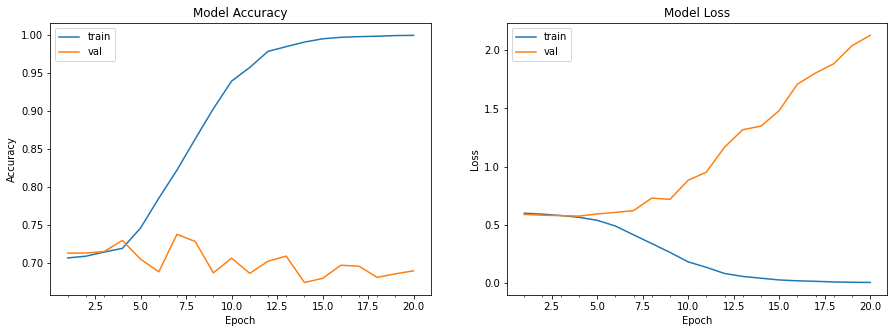

In [0]:
try_1_hist=model.fit(X_train,y_train,batch_size=batch_size,epochs=20,verbose=1,validation_data=(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


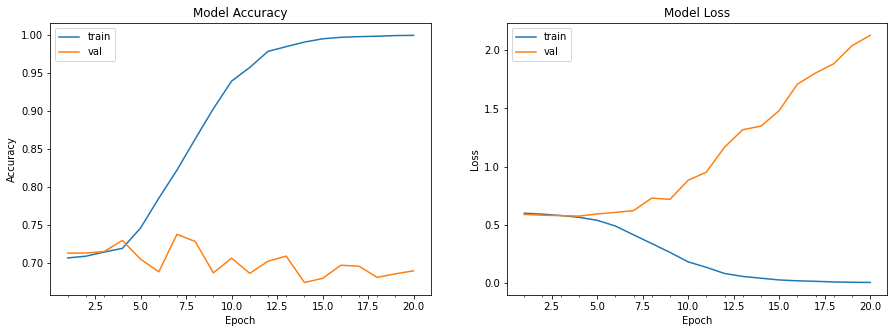

In [0]:
plot_model_history(try_1_hist)

**Results:**

 expected this kind of behaviour: 

 * Training loss: 0.0045 VS validation_loss: 2.1274 
 
 * Training accuracy: 0.9994 - validatin_accuracy: 0.6893

As we can see the model is overfeeding to the training data and not generalizing and this is expected because we don't have enough data to train the model from scratch and make it able to extract the correct features needed to make the prediction. 

$\implies$ Because we are limited, data wise, especially with the RAM and we used already 70% of the data for the training.  One way to help with the overfiting is using Dropout layer. 

**Dropout Layers**: 

During training, some number of layer outputs are randomly ignored or dropped out. By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections.

A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training.  dropout  offers a very computationally cheap regularization method to reduce overfitting and improve generalization error.


* In the below snippet of code w train again the previous model, but we add Dropout layers to avoid the overfitting of the model.

* With the data we have and this architecture of the model using high drop rate  actually made the results worse  and that is understandable because we keep turning off the unit in the fully connected layer, and if we turn off frequently a lot of units we prevent the model from learning, Thus the use of a small  drop rate = 0.1 to help with the overfitting without making the leaning process noisy and weak due to the dropout perturbation. 

* Also I added batch normalization layer before the activation layer .
The basic idea behind batch normalization is to limit covariate shift by normalizing the activations of each layer (transforming the inputs to be mean 0 and unit variance). This, supposedly, allows each layer to learn on a more stable distribution of inputs, and would thus accelerate the training of the network

In [0]:
batch_size=20
learning_rate=0.0001
dropout_rate=0.1

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(400, 400, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding="SAME"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 400, 400, 64)      1792      
_________________________________________________________________
activation_8 (Activation)    (None, 400, 400, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 32)      18464     
_________________________________________________________________
activation_9 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)     

In [0]:
try_2_hist=model.fit(X_train,y_train,batch_size=batch_size,epochs=20,verbose=1,validation_data=(X_test,y_test))

Train on 3500 samples, validate on 1500 samples
Epoch 1/20
3500/3500 [==============================] - 53s 15ms/step - loss: 0.6966 - accuracy: 0.5897 - val_loss: 0.6041 - val_accuracy: 0.7107
Epoch 2/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.6106 - accuracy: 0.6789 - val_loss: 0.6458 - val_accuracy: 0.6513
Epoch 3/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.5496 - accuracy: 0.7371 - val_loss: 0.5986 - val_accuracy: 0.7027
Epoch 4/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.4723 - accuracy: 0.7829 - val_loss: 0.6095 - val_accuracy: 0.7140
Epoch 5/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.3791 - accuracy: 0.8554 - val_loss: 0.6828 - val_accuracy: 0.5907
Epoch 6/20
3500/3500 [==============================] - 45s 13ms/step - loss: 0.2843 - accuracy: 0.9106 - val_loss: 0.6201 - val_accuracy: 0.6920
Epoch 7/20
3500/3500 [==============================] - 45s 13ms/step - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


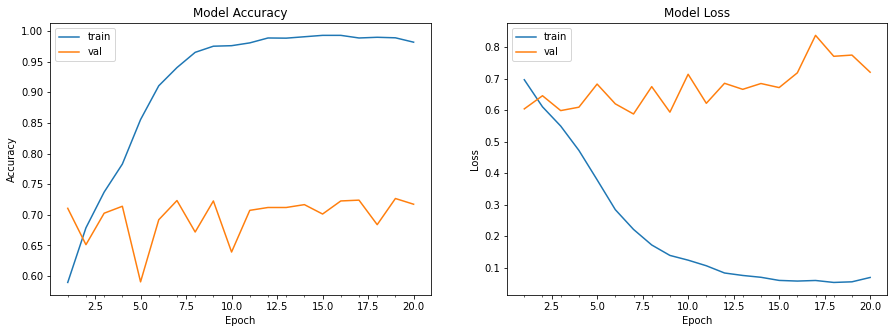

In [0]:
plot_model_history(try_2_hist)

**Results:**
  * Previous Model: 
    * Training loss: 0.0045 VS validation_loss: 2.1274 
    * Training accuracy: 0.9994 VS validatin_accuracy: 0.6893
  * Current Model : 
    * Training loss: 0.0690  VS validation_loss:  0.7204
    * Training accuracy:  0.9817 VS  validatin_accuracy: 0.7173
  * comparison:   
    * Training loss, increased but the validation loss decreased, which means we managed to decrease the overfitting  of the model as expected, but we didn't eliminate it a problem we just decreased it's effect.  
    * Validation accuracy also increased to 0.71 but this is still not sufficient we need to improve the model much more.  

$\implies$ we can see that the result improved by using the batch normalization and dropout layer, yet we still suffer from the overfitting, which is a very common phenomena when it comes to neural networks, because they tend to overfit the data, especially if poorly trained (small dataset), such a model which solves complex problem need a whole lot of data, and getting vast amounts of labeled data for supervised models can be really difficult, considering the time and effort it takes to label data.

$\implies$ Thus, the key motivation, to use, transfer learning in order to make better results 

## Classification Using Transfor learning :

***What is Transfer Learning?***

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.

For this type of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet (there are  about 14 million images in the dataset, with arround 21000 classes ).

$\implies$ These models can take days or weeks to train on such data amount using modern hardware .

This approach is effective because the models were trained on a large corpus of photographs and require the model to make predictions on a relatively large number of classes, in turn, requiring that the model efficiently learn to extract features from photographs in order to perform well on the problem.

$\implies $ Thus, we use these models that learnt to extract the right  features to make a good classification and incorporate them in our model to make the prediction if there is a person in the artwork or not 


Available Models on Keras for image classification with weights trained on ImageNet:

    Xception
    VGG16
    VGG19
    ResNet, ResNetV2
    InceptionV3
    InceptionResNetV2
    MobileNet
    MobileNetV2
    DenseNet
    NASNet


###Chosing best Pretrained model

In [0]:
shape=(400,400,3)
unfrozen_layers=10
lr=0.00006
dropout_rate=0.1
batch_size = 16
epochs = 10

In [0]:
#List of pretrained models available on Keras.
base_models={"Xception":keras.applications.xception.Xception,
"InceptionV3":keras.applications.inception_v3.InceptionV3,
"InceptionResNetV2":keras.applications.inception_resnet_v2.InceptionResNetV2,
"VGG16":keras.applications.vgg16.VGG16,
"VGG19":keras.applications.vgg19.VGG19,
"MobileNetV2":keras.applications.mobilenet_v2.MobileNetV2,
"ResNet50":keras.applications.resnet.ResNet50,
"ResNet101":keras.applications.resnet.ResNet101,
"ResNet152":keras.applications.resnet.ResNet152,
"ResNet50V2":keras.applications.resnet_v2.ResNet50V2,
"ResNet101V2":keras.applications.resnet_v2.ResNet101V2,
"ResNet152V2":keras.applications.resnet_v2.ResNet152V2,
"MobileNet":keras.applications.mobilenet.MobileNet,
"DenseNet121":keras.applications.densenet.DenseNet121,
"DenseNet169":keras.applications.densenet.DenseNet169,
"DenseNet201":keras.applications.densenet.DenseNet201,
"NASNetLarge":keras.applications.nasnet.NASNetLarge,
"NASNetMobile":keras.applications.nasnet.NASNetMobile}

In [0]:
def plot_history(history) :
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
def build_model(base): 
  #Function That build the model and return the compiled version of it 
  for layer in base.layers: 
    layer.trainable=False  # We freeze all the layers of the pre-trained  model 

  for layer in base.layers[:trainable]:  
      layer.trainable=True # unfreeze the layers we want to train .

  model = keras.Sequential()
  model.add(base)
  model.add(Flatten()) 
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

  return model

In [0]:
def run(base_model): 
  #function that will fit all the availble kears pretrained models to determine which is better suitable for our case.
  #based on the metrics : validation loss & validation accuracy & F1 
  
  for base in base_model: # loop over all availble pretrained models in keras 
    print(base)
    base=base_model[base](include_top=False, weights='imagenet', input_shape=shape) # load the pretrained model with imagnet weights 
    model=build_model(base) # build the model using the basemodel we loaded 
    #model.load_weights("weights.best.hdf5")
    # ModelCheckpoint is a callback function in keras that saves the best model over the training epochs 
    checkpoint = ModelCheckpoint(ROOT+prior+'.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
    #fitting the model and saving the history of the training to compare the models 
    history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs, validation_data=(X_test, y_test),callbacks=[checkpoint])
    #plot the accuracy and loss 
    plot_history(history)
    #Test the performance of the model (F1 score )
    y_pred_1=model.predict_classes(X_test)
    f1_score_1=f1_score(y_test, y_pred_1,average="weighted")
  
    print("""Model: {}
Best Acc: {}
F1 Test: {}

""".format(prior,max(history.history['val_accuracy']),f1_score_1))
    

In [0]:
run(base_model)

$\implies$ based on the output of the run function the best model among the ones available in keras is "InceptionResNetV2" it has almost the same accuracy with "Xception" but achieved better F1 Score, since the evaluation in this challenge is based on Mean F1 score. I will use "InceptionResNetV2" as a pretrained model.

###  Classification Using INCEPTION pretrained model  from  GOOGLE : 


The idea behind the Transfer learning using pretrained model is:

 * On the top of the pretrained model we add our fully connected layer in order to make a binary classification (instead of the 1000 class classification) 
 
 * So the pretrained model extract the features and passed to our fully connected layer to make the classification. 

* Since imagenet classes contains "person" classifies some of  the features that pretrained extracted fit our problem of classification Thus we don't want to lose these weights or ruin it while training the model. that is why we freeze the layer of the pretrained model to keep these weights constant while training.

* All imagenet Images are of a shape (244,244,3), since I noticed that bigger shapes gives better results because it contains more information, we will use images of shape (400,400,3)  thus we need to fine-tune  the pretrained model for this kind of images. $\implies$  unfreeze the bottom layers to allow the model to adapt to the new type of data and we should use a very small learning rate, so that we don't lose the performance of the pretrained model. 


* Why we don't train the top layers instead, as I dug into the literature, I found out that if the data set on which the pretrained model is trained contains the same class we  are predicting it would be wise to freeze these layers to conserve the features already learnt on a bigger data. 


In [0]:
input_shape=(400,400,3)
trainable=15 # number of layers we will unfreeze 
lr=0.00001 # learning rate 
batch_size = 18
epochs = 10




In [0]:
# load the base pretarined  model without the top Fully conected layer , because we don't need it ( 1000 class ) we will replace it with our fully conected layer.
base = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                          weights='imagenet',
                                          input_shape=input_shape)

for layer in base.layers: 
  layer.trainable=False 

for layer in base.layers[:trainable]:  
    layer.trainable=True

    
model = keras.Sequential()
model.add(base) # add the pretrained model 
# on top of it we add our Fulmy connected layer.
model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr),
          metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 11, 11, 1536)      54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 185856)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               47579392  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

In [0]:

# EarlyStopping is a callback function that stops the training if the val_ loss didsn't imporeve for "paitence" epochs.
# This is saves the time and also prevent the overfitting  if we run the model for many epochs , it will certainly overfit .
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4) 
# ModelCheckpoint is a callback function in keras that saves the best model over the training epochs 
cp = ModelCheckpoint('BEST_inception.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[cp,es]
)

Train on 3500 samples, validate on 1500 samples
Epoch 1/5
3500/3500 [==============================] - 610s 174ms/step - loss: 0.4302 - accuracy: 0.8214 - val_loss: 0.3898 - val_accuracy: 0.8347

Epoch 00001: val_accuracy improved from -inf to 0.83467, saving model to BEST_inception.hdf5
Epoch 2/5
3500/3500 [==============================] - 561s 160ms/step - loss: 0.2421 - accuracy: 0.9114 - val_loss: 0.3214 - val_accuracy: 0.8940

Epoch 00002: val_accuracy improved from 0.83467 to 0.89400, saving model to BEST_inception.hdf5
Epoch 3/5
3500/3500 [==============================] - 561s 160ms/step - loss: 0.1472 - accuracy: 0.9474 - val_loss: 0.4589 - val_accuracy: 0.7893

Epoch 00003: val_accuracy did not improve from 0.89400
Epoch 4/5
1998/3500 [================>.............] - ETA: 3:27 - loss: 0.0909 - accuracy: 0.9710

$\implies$ The performance of the model increased from accuracy = 0.71 to accuracy 0.91, that is thanks to the pretrained model, that helped in extracting the right features needed. 

but as we can see the Training loss is decreasing much more rapidly than the Validation loss and that is a sign of overfitting, The solution to this:

 * Make the fully connected layer more complex (add more hidden layer) $\implies$ this is time consuming and computationally complex. 
 
 * Thus solution 2: We add dropout layer, since this helps with overfitiing in our simple CNN model. 

#### Dealing with the over-fitting  of the model: ( Dropout )




As said above, a high drop rate prevent the model from appropriately leaning, thus I will use the same rate I used above drop_rate=0. 1

In [0]:
drop_rate=0.1

In [0]:
# load the base pretarined  model without the top Fully conected layer , because we don't need it ( 1000 class ) we will replace it with our fully conected layer.
base = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                          weights='imagenet',
                                          input_shape=input_shape)

for layer in base.layers: 
  layer.trainable=False 

for layer in base.layers[:trainable]:  
    layer.trainable=True

    
model = keras.Sequential()
model.add(base) # add the pretrained model 
# on top of it we add our Fulmy connected layer.
model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))# We added Dropout layers

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))# We added Dropout layers

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))# We added Dropout layers

model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))# We added Dropout layers

model.add(Dense(16, activation='relu'))
model.add(Dropout(dropout_rate))# We added Dropout layers

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr),metrics=['accuracy'])

model.summary()

In [0]:

# EarlyStopping is a callback function that stops the training if the val_ loss didsn't imporeve for "paitence" epochs.
# This is saves the time and also prevent the overfitting  if we run the model for many epochs , it will certainly overfit .
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4) 
# ModelCheckpoint is a callback function in keras that saves the best model over the training epochs 
cp = ModelCheckpoint('BEST_inception_v0.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[cp,es]
)

$\implies$ As expected the dropout layers helped with the overfitting, we decreased the val_loss from 0.6 (without drop out layer) to 0.4 (with the dropout layer) also the accuracy increased from 91% to 92.2%. 

$\implies$ Another clue about reducing the overfitting is that the rate on which the training loss decrease compared to the rate of the validation loss decrease is much slower, which mean we don't overfit very fast, thus we give time for the model to learn and generalize more. 



#### Adaptative learning rate : 

Deep learning neural networks are trained using the stochastic gradient descent optimization algorithms.

The learning rate may be the most important hyperparameter when configuring your neural network. because it is  a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

In our case, we are fine tuning a pretrained model, thus in order to keep the knowledge of that pretrained model we should use a small learning rate. 

The idea here, is with every epoch  the model is more fine-tuned thus we don't want to go far from that sub-optimal set of weights. with every epoch the model is closer to the optimal set of weights, so I decided to adapt my learning rate on every epoch so we don't diverge or get stuck in a local optimum.  


 $\implies$ I will keep decreasing the value of the learning rate with every epoch, so on the next epoch we fine tune the sub-optimal weights we found and not diverge from them.
 
 
 $\implies$ For updating the learning rate, I use  Keras callback function  LearningRateScheduler  to update to a learning rate while training the data.

Learning rate per epoch:


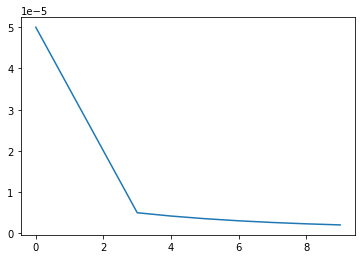

In [4]:
epochs = 10 # Number of epochs of the training 
start_lr = 0.00005 # The start learning rate 
min_lr = 0.000001  # The minimal learning rate 
max_lr = 0.000005  # the maximal learning rate 
rampup_epochs = 3  # the epoch on which we no longer lineary deacrasing the leaning rate 
exp_decay = .8     # at somepoint we can't keep deacreasing the rate lineary
                   # because it will be so small to train the model, that is why after 
                   # the rampup epoch we add an exp decay. 

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs) + min_lr
    

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [0]:
 

batch_size = 22
epochs = 10
# LearningRateScheduleris a callbalck function from kears that update the learning rate during the training 
lr = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
# EarlyStopping is a callback function that stops the training if the val_ loss didsn't imporeve for "paitence" epochs.
# This is saves the time and also prevent the overfitting  if we run the model for many epochs , it will certainly overfit .
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4) 
# ModelCheckpoint is a callback function in keras that saves the best model over the training epochs 
cp = ModelCheckpoint('BEST_inception_v1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[lr,cp,es]
)

Train on 3500 samples, validate on 1500 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-05.
3500/3500 [==============================] - 279s 80ms/step - loss: 0.4173 - accuracy: 0.8231 - val_loss: 0.1877 - val_accuracy: 0.9353

Epoch 00001: val_accuracy improved from -inf to 0.93533, saving model to BEST_inception_v1.hdf5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3.5000000000000004e-05.
3500/3500 [==============================] - 193s 55ms/step - loss: 0.1570 - accuracy: 0.9463 - val_loss: 0.2449 - val_accuracy: 0.9327

Epoch 00002: val_accuracy did not improve from 0.93533
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
3500/3500 [==============================] - 193s 55ms/step - loss: 0.0656 - accuracy: 0.9786 - val_loss: 0.2806 - val_accuracy: 0.9427

Epoch 00003: val_accuracy improved from 0.93533 to 0.94267, saving model to BEST_inception_v1.hdf5
Epoch 4/10

Epoch 00004: LearningR

**results: ** Clearly, using the adaptive learning rate the validation accuracy increased from 92.2% to 94.2% and the validation loss decreased from 0.4  to 0.2 

$\implies$ as we expected using more suitable learning rate  keeps us on from diverging to a sub optimal set of weights. and thus increase the performance of our model (F1 scores =94. 26 % of the test data) 

**Insights: **

  In order to improve the performance of the model we can apply one of these techniques: 
     * Data balancing: Because our data isn't balanced the positive class is only 30% vs 70%  for negative class.
      * Data Augmentation: in order to train the models on more data and expect better performances.

####Data Augmentation 


The idea here is to combine the two previously mentioned techniques, we can do data augmentation and data balancing at the same time. 

 * in order to balance the data we need to duplicate some data from the positive class 
 * for data augmentation, we create new data based on the date we got by applying some transformations.$\implies$ we can do both, if we do the data augmentation on the positive class data: that make the data balanced because we generate new data for the positive class and at the same time increase the total number of data  

 Another important point is  that we should not apply data augmentation before splitting the data, because that may cause we have the same image in the train set and test set  and testing a model on data that he have seen before is  misleading. 


In [0]:
X_pos_class=X_train[y_train==1] # select the positiv class observations! 

datagen = ImageDataGenerator( # we use a class in keras called ImageDataGenerator that generate new data based on the transformations we choose. 
    horizontal_flip=True, # flip the image 
    rotation_range=90,    # rotate the image with an angle between 0 and 90°
    brightness_range=[0.2,1.0]  # change the brightness of the images 
)

# there is much more transformations , like width shift ,crop and zoom .. we didn't use these because we risk if we apply one of these the person 
# in the image is no longer visible thus we would be feeding wrong data to our model and that for sure will effect the performances,
# That is why we avoid such transformations. 

it = datagen.flow(X_pos_class, batch_size=250) # an iterator that will point on a batch of 250 new generated images 
# in order to balance the data we need 1000 more positive class images
for i in range(4):
  # generate batch of images
  batch = it.next()
  batch=batch.astype("float32")/255 # due to the change of brightness we images are in the range of [0,255] again we need to normalize 
  X_train=np.concatenate((X_train, batch), axis=0) # add the batch to the train data 
  y_train=np.concatenate((y_train, np.ones(batch.shape[0])),axis=0) # add correct labels to train labels 

In [0]:
# with the previous snippret of code we have 1000 image of positive class at the end , we need to shuffle the data . 
p = np.random.permutation(len(X_train))
X_train=X_train[p]
y_train=y_train[p]


(4500, 400, 400, 3) (4500,)


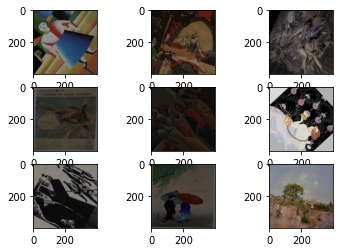

In [0]:
# generate samples and plot it 
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[4].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

training the model on the augmented & balanced data didn't improve the performance but made it worse (F1_old=94 => F1_new=92).


I didn't expect such behaviour because usually increasing the training data improves the model, but not this time. 
 The only explanation I can come to is that when we do the rotation, we do interpolation to calculate new values, maybe that rotation&interpolation made the person in the artwork not visible that can explain it because we would have ruined some data and fed it to the model. 

# Submit : 


In [0]:
gdd.download_file_from_google_drive(file_id='1APFwkD644qYhGa0bxslQCGZHa2y3U4mo',dest_path='./BEST_inception_v1.hdf5')
model.load_weights("BEST_inception_v1.hdf5")
y=model.predict_classes(data)
df_submission = pd.read_csv(ROOT+'/test.csv')
predict=pd.DataFrame(y,index=df_submission.index, columns=['person'])
predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   person  5000 non-null   float32
dtypes: float32(1)
memory usage: 19.7 KB


In [0]:

df_submission['person'] = predict['person'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(10))
df_submission.to_csv('./exemple_test.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

        name  person
0  IM_005000       1
1  IM_005001       0
2  IM_005002       0
3  IM_005003       1
4  IM_005004       0
5  IM_005005       0
6  IM_005006       0
7  IM_005007       1
8  IM_005008       0
9  IM_005009       1


In [0]:
files.download("./exemple_test.csv")